In [ ]:
import torch, platform
print("Python version:", platform.python_version())
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("GPU not detected")

Python version: 3.12.12
Torch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


For persistent storage mountung google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# setup project dirrectory, sub folders on DRive
PROJECT_DIR = '/content/drive/MyDrive/continual_learning_project'
for sub in ['environmentSetup','data', 'models', 'results', 'plots', 'logs']:
    os.makedirs(f"{PROJECT_DIR}/{sub}", exist_ok=True)
print("Project folder created successfully at:", PROJECT_DIR)

Project folder created successfully at: /content/drive/MyDrive/continual_learning_project


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

In [ ]:
# converts images into numerical tensors suitable for neural networks
# Converts image (0-255) → normalized float tensor (0-1)
transform = transforms.Compose([
    transforms.ToTensor()
])

now get the MNIST dataset and split into train, validaate and test.

In [ ]:
import json

full_train_dataset = datasets.MNIST(root=f'{PROJECT_DIR}/data', train=True,  download=True, transform=transform)
test_dataset = datasets.MNIST(root=f'{PROJECT_DIR}/data', train=False, download=True, transform=transform)

SPLIT_DIR = f"{PROJECT_DIR}/data/splits"
os.makedirs(SPLIT_DIR, exist_ok=True)

# seed to ensure same splits everytime
SEED = 42
g = torch.Generator().manual_seed(SEED)

# split test set into test and alidate
total_test = len(test_dataset)
val_size   = total_test // 2
test_size  = total_test - val_size
val_dataset, final_test_dataset = random_split(test_dataset, [val_size, test_size], generator=g)

loader_kwargs = dict(batch_size=64, num_workers=2, pin_memory=torch.cuda.is_available())
train_loader = DataLoader(full_train_dataset, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_dataset,      shuffle=False, **loader_kwargs)
test_loader  = DataLoader(final_test_dataset, shuffle=False, **loader_kwargs)

print("Train samples:", len(full_train_dataset))
print("Validation samples:", len(val_dataset))
print("Final Test samples:", len(final_test_dataset))

split_indices = {
    "train": list(range(len(full_train_dataset))),
    "val":   val_dataset.indices,
    "test":  final_test_dataset.indices,
}
with open(f"{SPLIT_DIR}/train_indices.json","w") as f: json.dump(split_indices["train"], f)
with open(f"{SPLIT_DIR}/val_indices.json","w")   as f: json.dump(split_indices["val"],   f)
with open(f"{SPLIT_DIR}/test_indices.json","w")  as f: json.dump(split_indices["test"],  f)




Train samples: 60000
Validation samples: 5000
Final Test samples: 5000


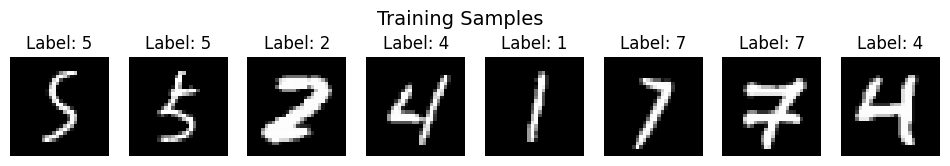

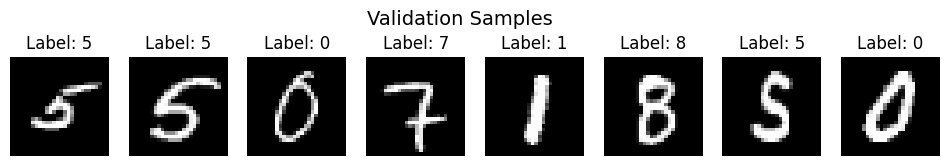

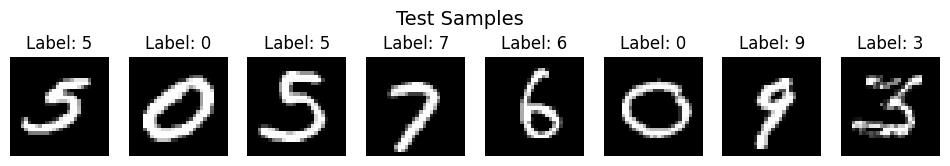

In [ ]:
import matplotlib.pyplot as plt
def visualizeImages(data_loader, title="Sample Images"):
    images, labels = next(iter(data_loader))
    images, labels = images[:8], labels[:8]

    fig, axes = plt.subplots(1, len(images), figsize=(12, 2))
    fig.suptitle(title, fontsize=14)
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
    plt.show()
visualizeImages(train_loader, title="Training Samples")
visualizeImages(val_loader,   title="Validation Samples")
visualizeImages(test_loader,  title="Test Samples")

Verify class balance

In [ ]:
from collections import Counter

labels = [label for _, label in full_train_dataset]
print(Counter(labels))

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


Create a baseline model to compare against.
For task 1 -> only want pictures of 0 and 1; for task 2 only 2 and 3 pictures needed and so on.  
train per task on only that task’s digits,

after each task, evaluate on all tasks seen so far (0..t) on val + test,

log to CSV,

plot avg accuracy vs task index (to show forgetting).

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# five binary tasks (Split-MNIST style)
TASKS = [(0,1), (2,3), (4,5), (6,7), (8,9)]

class TwoClassWrap(Dataset):
    def __init__(self, base_ds, a, b):
        self.base = base_ds
        self.keep = [i for i in range(len(base_ds)) if base_ds[i][1] in (a, b)]
        self.map = {a:0, b:1}
    def __len__(self): return len(self.keep)
    def __getitem__(self, i):
        x, y = self.base[self.keep[i]]
        return x, self.map[int(y)]

def make_task_loaders(train_ds, val_ds, test_ds, pair, batch=64):
    a, b = pair
    tr = TwoClassWrap(train_ds, a, b)
    va = TwoClassWrap(val_ds,   a, b)
    te = TwoClassWrap(test_ds,  a, b)
    kw = dict(batch_size=batch, num_workers=2, pin_memory=torch.cuda.is_available())
    return (DataLoader(tr, shuffle=True,  **kw),
            DataLoader(va, shuffle=False, **kw),
            DataLoader(te, shuffle=False, **kw))


In [ ]:
# baseline model helper
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP2(nn.Module):
    def __init__(self, hidden=256):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden)
        self.fc2 = nn.Linear(hidden, 2)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def train_epoch(model, loader, opt, crit):
    model.train(); tot=0; cor=0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward(); opt.step()
        cor += (logits.argmax(1)==yb).sum().item()
        tot += xb.size(0)
    return cor/tot

@torch.no_grad()
def eval_acc(model, loader):
    model.eval(); tot=0; cor=0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        cor += (model(xb).argmax(1)==yb).sum().item()
        tot += xb.size(0)
    return cor/tot

In [ ]:
#  baseline model sequential run and log per task metrics
import os, pandas as pd, numpy as np, random, matplotlib.pyplot as plt

# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

RESULTS_DIR = f"{PROJECT_DIR}/results"
PLOTS_DIR   = f"{PROJECT_DIR}/plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

EPOCHS_BASELINE = 5
BATCH = 64
LR = 1e-3


train_base = full_train_dataset
val_base   = val_dataset
test_base  = final_test_dataset

model = MLP2().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
crit  = nn.CrossEntropyLoss()

rows = []

for t_idx, pair in enumerate(TASKS):
    # loaders for the CURRENT task
    tr_loader, va_loader_curr, te_loader_curr = make_task_loaders(train_base, val_base, test_base, pair, batch=BATCH)

    # train on current task only
    for _ in range(EPOCHS_BASELINE):
        _ = train_epoch(model, tr_loader, opt, crit)

    # evaluate on ALL SEEN TASKS so far (0..t_idx) to measure forgetting
    for p_eval in TASKS[:t_idx+1]:
        _, va_eval, te_eval = make_task_loaders(train_base, val_base, test_base, p_eval, batch=BATCH)
        acc_val = eval_acc(model, va_eval)
        acc_tst = eval_acc(model, te_eval)
        rows.append(dict(
            method="baseline",
            after_task=t_idx,
            eval_on=str(p_eval),
            val_acc=acc_val,
            test_acc=acc_tst,
        ))

df = pd.DataFrame(rows)
csv_path = f"{RESULTS_DIR}/baseline_history.csv"
df.to_csv(csv_path, index=False)
print("saved:", csv_path)
df.tail()


saved: /content/drive/MyDrive/continual_learning_project/results/baseline_history.csv


,method,after_task,eval_on,val_acc,test_acc
10,baseline,4,"(0, 1)",0.168317,0.166335
11,baseline,4,"(2, 3)",0.694199,0.663415
12,baseline,4,"(4, 5)",0.203463,0.195789
13,baseline,4,"(6, 7)",0.853266,0.855701
14,baseline,4,"(8, 9)",0.993704,0.993204


In [ ]:
MODELS_DIR = f"{PROJECT_DIR}/models"
os.makedirs(MODELS_DIR, exist_ok=True)

baseline_path = f"{MODELS_DIR}/baseline_model.pth"
torch.save(model.state_dict(), baseline_path)

print(f"Baseline model saved at: {baseline_path}")


Baseline model saved at: /content/drive/MyDrive/continual_learning_project/models/baseline_model.pth


EWC APPLICATION

In [ ]:
import torch
import torch.nn as nn

class EWC:
    def __init__(self, model, dataloader, device):
        self.device = device
        self.params = {
            name: p.clone().detach()
            for name, p in model.named_parameters()
            if p.requires_grad
        }

        self.fisher = self._compute_fisher(model, dataloader)

    def _compute_fisher(self, model, dataloader):

        model.eval()
        crit = nn.CrossEntropyLoss()

        fisher = {
            name: torch.zeros_like(p, device=self.device)
            for name, p in model.named_parameters()
            if p.requires_grad
        }

        n_batches = 0

        for xb, yb in dataloader:
            xb, yb = xb.to(self.device), yb.to(self.device)

            model.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)   # negative log-likelihood up to constant
            loss.backward()

            for name, p in model.named_parameters():
                if p.grad is None or not p.requires_grad:
                    continue
                fisher[name] += (p.grad.detach() ** 2)

            n_batches += 1

        # average over batches
        for name in fisher:
            fisher[name] /= max(n_batches, 1)

        return fisher

    def penalty(self, model):
        """
        EWC penalty for the current model relative to this task's snapshot.
        Returns a scalar tensor.
        """
        loss = 0.0
        for name, p in model.named_parameters():
            if not p.requires_grad:
                continue
            theta_old = self.params[name]
            F = self.fisher[name]
            loss = loss + (F * (p - theta_old) ** 2).sum()
        return loss


In [ ]:
# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

RESULTS_DIR = f"{PROJECT_DIR}/results"
PLOTS_DIR   = f"{PROJECT_DIR}/plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# base datasets (same as baseline)
train_base = full_train_dataset
val_base   = val_dataset
test_base  = final_test_dataset

# hyperparameters
EPOCHS_EWC = 5     # you can set 3 to test quickly
BATCH      = 64
LR         = 1e-3
LAMBDA_EWC = 1000.0   # strength of EWC regularization (tune later)

model = MLP2().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
crit  = nn.CrossEntropyLoss()

ewc_tasks = []   # list of EWC objects, one per completed task
rows = []

for t_idx, pair in enumerate(TASKS):
    print(f"\n=== Training EWC on task {t_idx}: digits {pair} ===")
    # loaders for CURRENT task
    tr_loader, va_loader_curr, te_loader_curr = make_task_loaders(
        train_base, val_base, test_base, pair, batch=BATCH
    )

    # ---- train on current task with EWC penalty from all previous tasks ----
    for epoch in range(EPOCHS_EWC):
        model.train()
        total = 0
        correct = 0
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()

            logits = model(xb)
            task_loss = crit(logits, yb)

            # EWC penalty from all previous tasks
            if len(ewc_tasks) > 0:
                penalty = 0.0
                for ewc in ewc_tasks:
                    penalty = penalty + ewc.penalty(model)
                loss = task_loss + LAMBDA_EWC * penalty
            else:
                loss = task_loss

            loss.backward()
            opt.step()

            correct += (logits.argmax(1) == yb).sum().item()
            total   += xb.size(0)

        train_acc = correct / max(total, 1)
        print(f" Task {pair}, epoch {epoch+1}/{EPOCHS_EWC}, train_acc={train_acc:.3f}")

    # ---- after finishing this task, compute Fisher + snapshot for EWC ----
    print("  Computing Fisher for this task (EWC stats)...")
    ewc_obj = EWC(model, tr_loader, device)
    ewc_tasks.append(ewc_obj)

    # ---- evaluate on ALL tasks seen so far (0..t_idx) ----
    for p_eval in TASKS[:t_idx+1]:
        _, va_eval, te_eval = make_task_loaders(
            train_base, val_base, test_base, p_eval, batch=BATCH
        )
        acc_val = eval_acc(model, va_eval)
        acc_tst = eval_acc(model, te_eval)
        print(f"  Eval on task {p_eval}: val={acc_val:.3f}, test={acc_tst:.3f}")

        rows.append(dict(
            method="ewc",
            after_task=t_idx,
            eval_on=str(p_eval),
            val_acc=acc_val,
            test_acc=acc_tst,
        ))

df_ewc = pd.DataFrame(rows)
csv_path = f"{RESULTS_DIR}/ewc_history.csv"
df_ewc.to_csv(csv_path, index=False)
print("\nSaved EWC history to:", csv_path)
df_ewc.tail()


=== Training EWC on task 0: digits (0, 1) ===
 Task (0, 1), epoch 1/5, train_acc=0.996
 Task (0, 1), epoch 2/5, train_acc=0.999
 Task (0, 1), epoch 3/5, train_acc=0.999
 Task (0, 1), epoch 4/5, train_acc=1.000
 Task (0, 1), epoch 5/5, train_acc=1.000
  Computing Fisher for this task (EWC stats)...
  Eval on task (0, 1): val=0.999, test=1.000

=== Training EWC on task 1: digits (2, 3) ===
 Task (2, 3), epoch 1/5, train_acc=0.955
 Task (2, 3), epoch 2/5, train_acc=0.979
 Task (2, 3), epoch 3/5, train_acc=0.986
 Task (2, 3), epoch 4/5, train_acc=0.990
 Task (2, 3), epoch 5/5, train_acc=0.994
  Computing Fisher for this task (EWC stats)...
  Eval on task (0, 1): val=0.772, test=0.793
  Eval on task (2, 3): val=0.992, test=0.995

=== Training EWC on task 2: digits (4, 5) ===
 Task (4, 5), epoch 1/5, train_acc=0.978
 Task (4, 5), epoch 2/5, train_acc=0.996
 Task (4, 5), epoch 3/5, train_acc=0.998
 Task (4, 5), epoch 4/5, train_acc=0.999
 Task (4, 5), epoch 5/5, train_acc=0.999
  Computing F

,method,after_task,eval_on,val_acc,test_acc
10,ewc,4,"(0, 1)",0.235824,0.236056
11,ewc,4,"(2, 3)",0.799410,0.784390
12,ewc,4,"(4, 5)",0.250000,0.228421
13,ewc,4,"(6, 7)",0.928643,0.906155
14,ewc,4,"(8, 9)",0.993704,0.994175


In [ ]:
MODELS_DIR = f"{PROJECT_DIR}/models"
os.makedirs(MODELS_DIR, exist_ok=True)

ewc_path = f"{MODELS_DIR}/ewc_model.pth"
torch.save(model.state_dict(), ewc_path)

print(f"EWC model saved at: {ewc_path}")

EWC model saved at: /content/drive/MyDrive/continual_learning_project/models/ewc_model.pth


Saved comparison plot to: /content/drive/MyDrive/continual_learning_project/plots/baseline_vs_ewc_forgetting.png


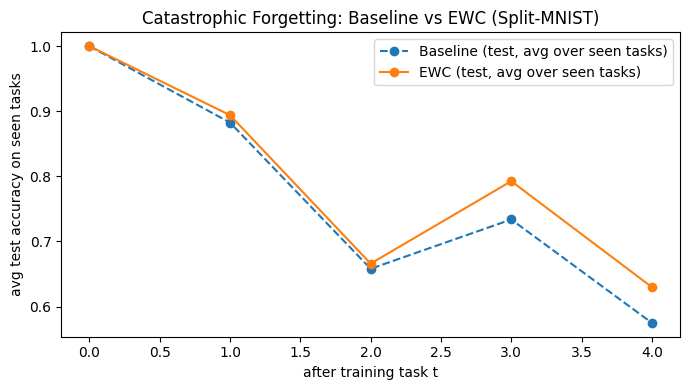

In [ ]:

df_base = pd.read_csv(f"{RESULTS_DIR}/baseline_history.csv")
df_ewc  = pd.read_csv(f"{RESULTS_DIR}/ewc_history.csv")

g_base = df_base.groupby("after_task")[["val_acc","test_acc"]].mean().reset_index()
g_ewc  = df_ewc.groupby("after_task")[["val_acc","test_acc"]].mean().reset_index()

plt.figure(figsize=(7,4))
plt.plot(g_base["after_task"], g_base["test_acc"],
         marker='o', linestyle='--', label="Baseline (test, avg over seen tasks)")
plt.plot(g_ewc["after_task"],  g_ewc["test_acc"],
         marker='o', linestyle='-',  label="EWC (test, avg over seen tasks)")
plt.xlabel("after training task t")
plt.ylabel("avg test accuracy on seen tasks")
plt.title("Catastrophic Forgetting: Baseline vs EWC (Split-MNIST)")
plt.legend(); plt.tight_layout()

plot_path = f"{PLOTS_DIR}/baseline_vs_ewc_forgetting.png"
plt.savefig(plot_path, dpi=160)
print("Saved comparison plot to:", plot_path)


EWC with grid search for hyperparameter tuning

In [27]:
import os, random, itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

RESULTS_DIR = globals().get("RESULTS_DIR", f"{PROJECT_DIR}/results")
os.makedirs(RESULTS_DIR, exist_ok=True)

train_base = globals().get("train_base", globals().get("full_train_dataset"))
val_base   = globals().get("val_base",   globals().get("val_dataset"))
test_base  = globals().get("test_base",  globals().get("final_test_dataset"))

assert train_base is not None and val_base is not None and test_base is not None, \
    "Missing datasets. Ensure full_train_dataset/val_dataset/final_test_dataset exist."

BATCH = 64
TASK_LOADERS = []
for pair in TASKS:
    trL, vaL, teL = make_task_loaders(train_base, val_base, test_base, pair, batch=BATCH)
    TASK_LOADERS.append((trL, vaL, teL))

print("Cached loaders for", len(TASK_LOADERS), "tasks.")


Cached loaders for 5 tasks.


In [28]:
class EWC:

    def __init__(self, model, train_loader, device, fisher_batches=5):
        self.device = device
        self.theta_star = {n: p.detach().clone() for n, p in model.named_parameters() if p.requires_grad}
        self.fisher = self._compute_fisher(model, train_loader, fisher_batches)

    def _compute_fisher(self, model, loader, fisher_batches):
        model.eval()
        crit = nn.CrossEntropyLoss()
        fisher = {n: torch.zeros_like(p, device=self.device) for n, p in model.named_parameters() if p.requires_grad}

        used = 0
        for b_idx, (xb, yb) in enumerate(loader):
            if fisher_batches is not None and b_idx >= fisher_batches:
                break
            xb, yb = xb.to(self.device), yb.to(self.device)

            model.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()

            for n, p in model.named_parameters():
                if p.requires_grad and p.grad is not None:
                    fisher[n] += (p.grad.detach() ** 2)

            used += 1

        used = max(1, used)
        for n in fisher:
            fisher[n] /= used
        return fisher

    def penalty(self, model):
        loss = 0.0
        for n, p in model.named_parameters():
            if p.requires_grad:
                loss = loss + (self.fisher[n] * (p - self.theta_star[n]) ** 2).sum()
        return loss

In [29]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def run_ewc_once_cached(lambda_ewc=100, lr=1e-3, epochs=2, fisher_batches=5, seed=42):
    set_seed(seed)
    model = MLP2(hidden=256).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()

    prev_ewc = []
    rows = []

    for t_idx, (trL, vaL, teL) in enumerate(TASK_LOADERS):
        # Train current task
        for _ in range(epochs):
            model.train()
            for xb, yb in trL:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad(set_to_none=True)
                logits = model(xb)
                loss = crit(logits, yb)

                if lambda_ewc > 0 and len(prev_ewc) > 0:
                    pen = 0.0
                    for e in prev_ewc:
                        pen = pen + e.penalty(model)
                    loss = loss + lambda_ewc * pen

                loss.backward()
                opt.step()

        # Snapshot fisher after finishing task
        prev_ewc.append(EWC(model, trL, device, fisher_batches=fisher_batches))

        # Eval on all seen tasks so far
        for j in range(t_idx + 1):
            _, va_j, te_j = TASK_LOADERS[j]
            rows.append({
                "after_task": t_idx,
                "eval_on": j,
                "val_acc": float(eval_acc(model, va_j)),
                "test_acc": float(eval_acc(model, te_j)),
                "lambda": lambda_ewc,
                "lr": lr,
                "epochs": epochs,
                "fisher_batches": fisher_batches
            })

    df_hist = pd.DataFrame(rows)

    # score: mean validation accuracy across seen tasks AFTER final task
    final_t = len(TASK_LOADERS) - 1
    score = float(df_hist[df_hist["after_task"] == final_t]["val_acc"].mean())
    return model, df_hist, score

In [30]:
# FAST grid (expand later if needed)
LAMBDA_GRID = [0, 50, 200, 500, 1000]     # keep small first
LR_GRID     = [1e-3, 5e-4]
EPOCHS_GRID = [1, 2]                      # tuning epochs (fast)
FISHER_GRID = [3, 5]                      # fisher batches (fast)

summaries = []
best = {"score": -1e9, "cfg": None, "hist": None, "state": None}

total = len(LAMBDA_GRID)*len(LR_GRID)*len(EPOCHS_GRID)*len(FISHER_GRID)
done = 0

for lam, lr, ep, fb in itertools.product(LAMBDA_GRID, LR_GRID, EPOCHS_GRID, FISHER_GRID):
    done += 1
    print(f"[{done}/{total}] lambda={lam}, lr={lr}, epochs={ep}, fisher_batches={fb}")

    model_tmp, hist_tmp, score_tmp = run_ewc_once_cached(
        lambda_ewc=lam, lr=lr, epochs=ep, fisher_batches=fb, seed=42
    )

    summaries.append({
        "lambda": lam, "lr": lr, "epochs": ep, "fisher_batches": fb,
        "final_mean_val_acc": score_tmp
    })

    if score_tmp > best["score"]:
        best["score"] = score_tmp
        best["cfg"] = (lam, lr, ep, fb)
        best["hist"] = hist_tmp.copy()
        best["state"] = {k: v.detach().cpu().clone() for k, v in model_tmp.state_dict().items()}

df_sum = pd.DataFrame(summaries).sort_values("final_mean_val_acc", ascending=False)

# Save outputs with ewc_gridsearch naming
sum_path  = f"{RESULTS_DIR}/ewc_gridsearch_summary.csv"
best_path = f"{RESULTS_DIR}/ewc_gridsearch_best_history.csv"
model_path = f"{RESULTS_DIR}/ewc_gridsearch_best_model.pth"

df_sum.to_csv(sum_path, index=False)
best["hist"].to_csv(best_path, index=False)

# Save best model
best_model = MLP2(hidden=256).to(device)
best_model.load_state_dict({k: v.to(device) for k, v in best["state"].items()})
torch.save(best_model.state_dict(), model_path)

print("\nSaved:", sum_path)
print("Saved:", best_path)
print("Saved:", model_path)
print("Best cfg (lambda, lr, epochs, fisher_batches) =", best["cfg"], "score =", best["score"])
display(df_sum.head(10))


[1/40] lambda=0, lr=0.001, epochs=1, fisher_batches=3
[2/40] lambda=0, lr=0.001, epochs=1, fisher_batches=5
[3/40] lambda=0, lr=0.001, epochs=2, fisher_batches=3
[4/40] lambda=0, lr=0.001, epochs=2, fisher_batches=5
[5/40] lambda=0, lr=0.0005, epochs=1, fisher_batches=3
[6/40] lambda=0, lr=0.0005, epochs=1, fisher_batches=5
[7/40] lambda=0, lr=0.0005, epochs=2, fisher_batches=3
[8/40] lambda=0, lr=0.0005, epochs=2, fisher_batches=5
[9/40] lambda=50, lr=0.001, epochs=1, fisher_batches=3
[10/40] lambda=50, lr=0.001, epochs=1, fisher_batches=5
[11/40] lambda=50, lr=0.001, epochs=2, fisher_batches=3
[12/40] lambda=50, lr=0.001, epochs=2, fisher_batches=5
[13/40] lambda=50, lr=0.0005, epochs=1, fisher_batches=3
[14/40] lambda=50, lr=0.0005, epochs=1, fisher_batches=5
[15/40] lambda=50, lr=0.0005, epochs=2, fisher_batches=3
[16/40] lambda=50, lr=0.0005, epochs=2, fisher_batches=5
[17/40] lambda=200, lr=0.001, epochs=1, fisher_batches=3
[18/40] lambda=200, lr=0.001, epochs=1, fisher_batches=5

,lambda,lr,epochs,fisher_batches,final_mean_val_acc
38,1000,0.0005,2,3,0.627456
39,1000,0.0005,2,5,0.626534
36,1000,0.0005,1,3,0.625921
35,1000,0.0010,2,5,0.625656
37,1000,0.0005,1,5,0.622945
34,1000,0.0010,2,3,0.620431
31,500,0.0005,2,5,0.619202
28,500,0.0005,1,3,0.618857
29,500,0.0005,1,5,0.618429
23,200,0.0005,2,5,0.618411
